# Train, Test and Run Inference with the Segmentation Model

This notebook contains examples of how to use the full segmentation pipeline to train, test, and perform inference.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [7]:
import os
import yaml
import argparse


# Save program's directory
cwd = os.getcwd()
if cwd == '/content':  # If we are in colab, we mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change dir to where project is located
    os.chdir("drive/MyDrive/CoVision/segmentation")
    cwd = os.getcwd()
elif 'drive' in cwd:  # Already monted and changed dir
    pass
elif 'notebooks_segmentation' in os.listdir(cwd):  # Local machine case
    cwd = './'
else:  # If currently in notebook folder
    os.chdir('./..')
    cwd = './'
print(f'Current working directory: {cwd}\n')

# Read arguments from dict and store them as Namespace
with open(cwd + 'config_segmentation.yaml', 'r') as f:
    config_dict = yaml.safe_load(f)

# Update directories for colab
config_dict['data_args']['data_dir'] = os.path.join(cwd, config_dict['data_args']['data_dir'])
config_dict['training_args']['save_path'] = os.path.join(cwd, config_dict['training_args']['save_path'])
config_dict['inference_args']['output_dir'] = os.path.join(cwd, config_dict['inference_args']['output_dir'])

args = argparse.Namespace(**config_dict)
data_args = argparse.Namespace(**config_dict['data_args'])
training_args = argparse.Namespace(**config_dict['training_args'])
transformation_args = argparse.Namespace(**config_dict['transformation_args'])
inference_args = argparse.Namespace(**config_dict['inference_args'])

print(data_args, '\n')
print(training_args, '\n')
print(transformation_args, '\n')
print(inference_args, '\n')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: ./

Namespace(class_colors=[[255, 0, 0], [0, 0, 255], [0, 255, 0]], class_ids=[0, 1, 2], classes=['background', 'kit', 'membrane'], data_dir='./data_segmentation', resize_height=800, train_test_split=0.8, train_val_split=0.8) 

Namespace(batch_size=4, epochs=10, hidden_size=256, lr='5e-5', num_workers=0, save_path='./saved_models', scheduler_gamma=0.5, scheduler_step=10, seed=42) 

Namespace(affine_p=0.5, affine_scale=[1, 1.5], affine_translate_percent=[-0.1, 0.1], blur_limit=5, blur_p=0.8, color_jitter_brightness=0.1, color_jitter_contrast=0.1, color_jitter_p=0.5, color_jitter_saturation=0.1, downscale_max=0.35, downscale_min=0.2, downscale_p=0.5, gauss_noise_p=0.5, gauss_noise_var_limit=[50, 100], horizontal_flip_p=0.5, perspective_p=0.5, perspective_scale=[0.05, 0.1], rotate_limit=80, rotate_p=0.8) 

Namespace(mask_thresholds=[0.7, 0.7], output_dir='./results', score_thresholds=[0.85, 0.85]) 

The autoreload extension is already loaded. To reload it, use:


## Trainer

We use this section to train the model

In [8]:
from trainer_segmentation import TrainerSegmentation
from utils_segmentation.visualization import plot_metrics

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


In [ ]:
# Set some training parameters (for hyperparameter search)
args.training_args['epochs'] = 1
args.training_args['num_workers'] = 2
args.training_args['batch_size'] = 8
args.training_args['learning_rate'] = 1e-4
args.training_args['scheduler_step'] = 20
args.training_args['scheduler_gamma'] = 0.5

args.inference_args['mask_thresholds'] = [0.75, 0.75]

# To train from scratch
trainer = TrainerSegmentation(args=args, kit_id='aconag', do_validation=True, val_set='val', shots=10)

# To resume from saved state
# state_path = os.path.join(cwd + 'saved_models/2024-03-06_13.04.44_best.state')
# trainer = TrainerSegmentation.from_saved_state(state_path, new_epochs=150)

In [ ]:
trainer.train(save_bool=True)

In [ ]:
metrics_train_df, metrics_val_df = trainer.get_metrics()
plot_metrics(metrics_val_df)

## Tester

In this section we test models on different datasets, like train, val and test sets.

In [4]:
from tester_segmentation import TesterSegmentation
from model_segmentation import get_segmentation_model

In [16]:
# Load trained model's state
state_path = os.path.join(training_args.save_path, '2024-03-06_13.04.44_best.state')
state = torch.load(state_path, map_location='cpu')
model = get_segmentation_model(len(data_args.classes), training_args.hidden_size)
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [17]:
tester = TesterSegmentation(args, model=model, device=None)

Loaded 7 image and mask paths for aconag test kit in val data mode


  0%|          | 0/4 [00:00<?, ?it/s]

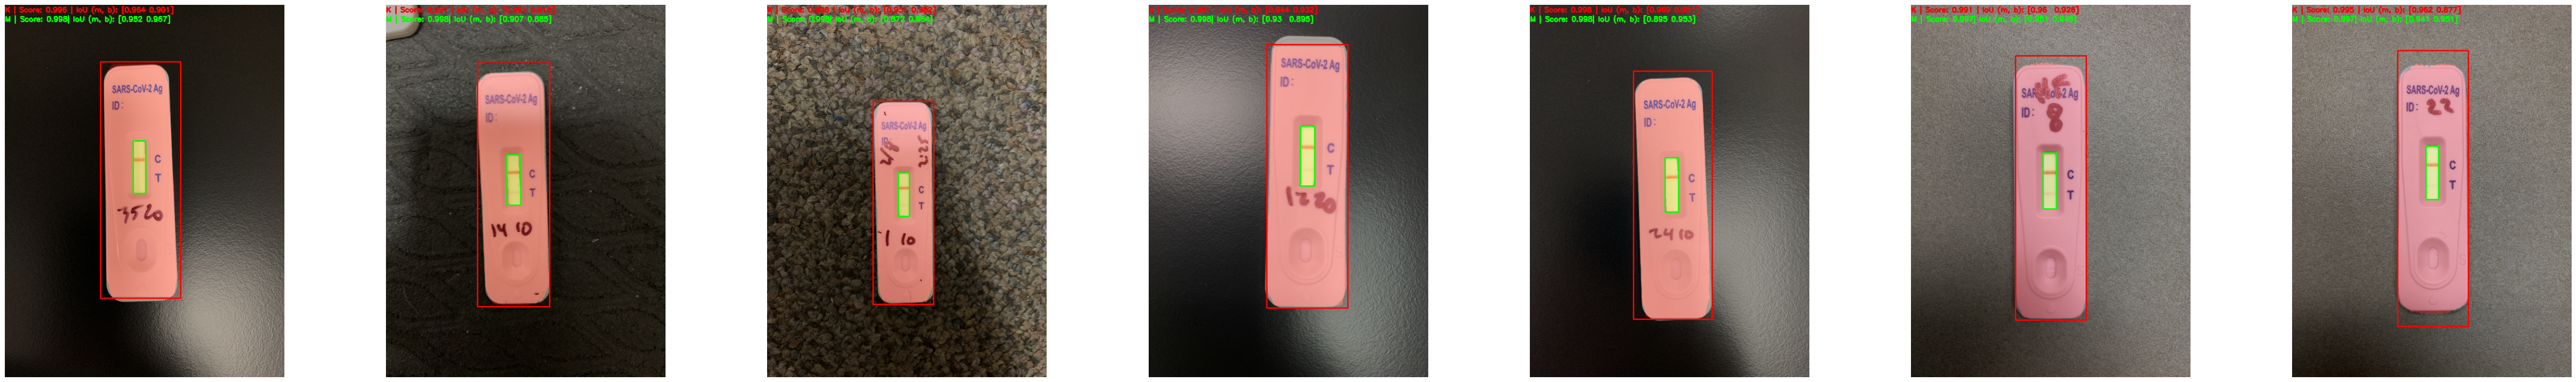

Mean metrics
scores_kit: 0.9959
scores_membrane: 0.9978
iou_masks_kit: 0.9586
iou_masks_membrane: 0.9212
iou_boxes_kit: 0.9268
iou_boxes_membrane: 0.9228


In [27]:
kit_id = 'aconag'
data_mode = 'val'
metrics_test_df = tester.test(kit_id=kit_id, data_mode=data_mode, show_bool=True, save_bool=True, save_filename='v0')